# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('Udacity_Starbucks/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Udacity_Starbucks/profile.json', orient='records', lines=True)
transcript = pd.read_json('Udacity_Starbucks/transcript.json', orient='records', lines=True)

# 1. Data Exploration

In [2]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
# Check the shortest and longest duration
print('Duration(day): shortest = ' , portfolio.duration.min(), ' , longest = ', portfolio.duration.max())

Duration(day): shortest =  3  , longest =  10


In [5]:
profile.sample(10)

,gender,age,id,became_member_on,income
12748,M,40,8b15b7b0e20a4ee7b6c0104a4347056b,20170728,61000.0
6435,M,59,436e0674e0094943aef62cfcfdb9d3c3,20170102,48000.0
15013,F,53,39b5141021e94f5ab6ac11139e61b582,20180303,42000.0
16565,None,118,ce96fff5ef0a41e1a217728a81f6722a,20160322,NaN
6239,F,55,3c614a56b49f4cad85569da0c814f4b2,20180611,79000.0
6359,F,60,da37f5aae7834a9aa6eb19a3e4ce776a,20131027,87000.0
444,M,66,3f244f4dea654688ace14acb4f0257bb,20180703,71000.0
13090,F,64,d5a7f83fb3ec4c9983d1c55364eb87c4,20171014,63000.0
1121,F,69,b463e46aa28748849542d6f24d775240,20161115,74000.0
2647,M,62,9b0cdf56c54f4e52a971f90936e46607,20150121,72000.0


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
# Check the smallest and largest of the numbers
print('Member Since: first date = ' , profile.became_member_on.min(), ' , latest date = ', profile.became_member_on.max())
print('Age: smallest = ' , profile.age.min(), ' , oldest = ', profile.age.max())
print('Income: smallest = ' , profile.income.min(), ' , biggest = ', profile.income.max())

Member Since: first date =  20130729  , latest date =  20180726
Age: smallest =  18  , oldest =  118
Income: smallest =  30000.0  , biggest =  120000.0


The oldest age 118? We agree old people can still drink coffee but 118 seems doesn't make sense. Let's see how the age are distributed.

In [8]:
# List all age value and count
age_counts = profile['age'].value_counts().sort_index()

for age, count in age_counts.items():
    print(f"{age}: {count}")

18: 70
19: 135
20: 135
21: 140
22: 131
23: 126
24: 139
25: 136
26: 157
27: 139
28: 137
29: 129
30: 131
31: 113
32: 139
33: 152
34: 147
35: 118
36: 175
37: 197
38: 172
39: 182
40: 202
41: 189
42: 227
43: 215
44: 192
45: 231
46: 212
47: 232
48: 288
49: 321
50: 284
51: 363
52: 351
53: 372
54: 359
55: 350
56: 342
57: 353
58: 408
59: 359
60: 333
61: 309
62: 318
63: 338
64: 311
65: 280
66: 284
67: 317
68: 259
69: 242
70: 252
71: 230
72: 191
73: 209
74: 193
75: 159
76: 155
77: 141
78: 135
79: 117
80: 116
81: 118
82: 105
83: 102
84: 83
85: 70
86: 54
87: 66
88: 64
89: 53
90: 52
91: 47
92: 40
93: 29
94: 33
95: 22
96: 8
97: 13
98: 5
99: 5
100: 12
101: 5
118: 2175


In [9]:
unique_ids = len(profile['id'].unique())
print("Number of unique IDs:", unique_ids)

Number of unique IDs: 17000


In [10]:
transcript.sample(10)

,person,event,value,time
303566,54d60cf626294a1685867c5f31dbf7b8,transaction,{'amount': 3.09},702
105993,037c3e0c1cd6477dbe15812a05619fc5,transaction,{'amount': 8.72},306
245707,54ddebb6c4a744fab1b222aabf7581f6,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
88081,856a6b35bd6d428591546ccea00cfb29,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},222
242869,ffb7fc8ad0594248a49e210ff0217c2d,transaction,{'amount': 28.36},564
35819,c1c19469f3ad45c7abf9c1da01ee0b7a,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,72
203688,360b8705b0564f2194a16ec4866b1164,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},504
249990,d8ac2ffea6e742ef949e4d96097e5c5d,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576
29139,d3956fdde71b4aa08a7d081f282a914f,transaction,{'amount': 13.29},42
201223,30e1c4e2158a4aed8656781077bfe1fc,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},498


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [13]:
# Check the fastest and slowest time
print('Time(hour): fastest = ' , transcript.time.min(), ' , slowest = ', transcript.time.max())

Time(hour): fastest =  0  , slowest =  714


In [14]:
import random

# Randomly select one person and show whose transcripts
person_id = random.choice(transcript['person'])
transcript[transcript['person'] == person_id]

,person,event,value,time
3436,013f2c82889f4641a9b847a48861cce0,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
16255,013f2c82889f4641a9b847a48861cce0,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},6
32988,013f2c82889f4641a9b847a48861cce0,transaction,{'amount': 21.27},60
56666,013f2c82889f4641a9b847a48861cce0,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
70087,013f2c82889f4641a9b847a48861cce0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},174
87628,013f2c82889f4641a9b847a48861cce0,transaction,{'amount': 23.75},222
87629,013f2c82889f4641a9b847a48861cce0,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,222
114302,013f2c82889f4641a9b847a48861cce0,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
124590,013f2c82889f4641a9b847a48861cce0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
124591,013f2c82889f4641a9b847a48861cce0,transaction,{'amount': 22.9},336


# 2. Data Cleansing

## 2.1 Portfolio

In [15]:
def preprocess_portfolio(portfolio):
    # Split the channel values into separate strings
    portfolio['channels'] = portfolio['channels'].str.join(', ')

    # Create separate columns for each channel using get_dummies
    channels_df = portfolio['channels'].str.get_dummies(sep=', ')

    # Concatenate the new channels dataframe with the original portfolio dataframe
    portfolio_df = pd.concat([portfolio.drop('channels', axis=1), channels_df], axis=1)

    return portfolio_df

portfolio_df = preprocess_portfolio(portfolio)

In [16]:
portfolio_df

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## 2.2 Profile

In [17]:
def preprocess_profile(profile, cutoff_date='2018-12-31'):
    
    cutoff_date = pd.to_datetime(cutoff_date)

    profile_df = profile.copy()
    
    # Convert 'became_member_on' column to datetime type
    profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')

    # Rename the column to 'member_since'
    profile_df.rename(columns={'became_member_on': 'member_since'}, inplace=True)

    # Calculate the number of days between member_since and cutoff_date
    profile_df['days_since_join'] = (cutoff_date - profile_df['member_since']).dt.days
    
    # Drop rows which age is > 100
    profile_df = profile_df[profile_df['age'] <= 100]

    return profile_df

profile_df = preprocess_profile(profile)

In [18]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   gender           14820 non-null  object        
 1   age              14820 non-null  int64         
 2   id               14820 non-null  object        
 3   member_since     14820 non-null  datetime64[ns]
 4   income           14820 non-null  float64       
 5   days_since_join  14820 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 810.5+ KB


I planned to handle the null values after dropping the rows which age is > 100, but then I realize that all the age 118 rows are having null value in gender and income as the same time. After I removed those age 188 rows, null value of gender and income are not here anymore.

On the other hand, we think that the days after being a member can be one of the features which might be useful for predictive analysis so we will add this field to profile.

## 2.3 Transcript

In portfolio dataset duration are shown by day, to sync the unit of time, we will change 'time' from hours to days.

In [19]:
# Convert time from hours to days with one decimal place
transcript['day_since_start'] = (transcript['time'] / 24).round(1)
transcript = transcript.drop(columns='time')

In [20]:
transcript.sample(10)

,person,event,value,day_since_start
101329,ba8457f994234f27bb0703e60518ba26,transaction,{'amount': 2.54},11.5
271129,f490559d2e3d45be94bd05cbe025c721,transaction,{'amount': 5.14},24.8
100894,2a396eb0dba0431abd59e701ebe28cb9,transaction,{'amount': 21.56},11.5
194061,bfbb2bd21f3c41488c7f80b70abffaab,transaction,{'amount': 1.23},19.8
136510,4394b8bc2235422dbdeb3cdc4908b6c1,transaction,{'amount': 4.17},15.0
214105,a30db84597704ffa9ff25f14c3b2d807,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},21.0
57797,aab991c762f240d28ba259bde064aa44,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},7.0
165496,6332d144d8d54f08927de3c92363946d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,17.0
164393,afd3e2b3a0da49379b6afceaeb250aea,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},17.0
210399,d1c534d5e28647a79c5e6515ab9c7af4,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},21.0


In [21]:
# Function to extract offer_id from value column
def extract_offer_id(row):
    if row['event'] == 'offer received' or row['event'] == 'offer viewed':
        return row['value']['offer id']
    elif row['event'] == 'offer completed':
        return row['value']['offer_id']
    else:
        return np.nan

# Extract offer_id and amount from value column
transcript['offer_id'] = transcript.apply(extract_offer_id, axis=1)
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) and 'amount' in x else np.nan)

# Break down event column into binary columns
transcript_binary = pd.get_dummies(transcript['event'])

# Concatenate the binary columns and extracted columns to create the final DataFrame
transcript_df = pd.concat([transcript, transcript_binary], axis=1).drop(['event', 'value'], axis=1)

In [22]:
# Display new transcript dataframe
transcript_df.sample(10)

,person,day_since_start,offer_id,amount,offer completed,offer received,offer viewed,transaction
11819,714ffa98de8a485b88f5ec40a2de521d,0.0,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
81997,3a912dda124a43719e766fe8af45f565,8.5,NaN,13.56,0,0,0,1
226509,cafb4a8e15954efc83973d2607e5b66a,21.8,NaN,0.89,0,0,0,1
267216,2ab61c2469b74c17b79992f4aaeee110,24.5,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0
288146,7dfe7355623a45988127c78ac7504bbc,26.8,NaN,10.19,0,0,0,1
296216,e810c04debfd410db0a5665db72a4677,27.8,NaN,4.51,0,0,0,1
134085,970d5bbecdf4439caad43284bce5cb60,14.8,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0
202139,f6bd6dc5dc074183af8248e31c960ce5,21.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0
74755,08f478cb589a4dcb882a079b1ccffc20,7.5,5a8bc65990b245e5a138643cd4eb9837,NaN,0,0,1,0
292684,7a732c740d84488f99fbbaa55b6c144c,27.2,NaN,1.22,0,0,0,1


In [23]:
# Sort the DataFrame by person and day since start, and reset the index
transcript_df= transcript_df.sort_values(by=['person', 'day_since_start'], ignore_index=True)

# Rearrange the column order
transcript_df = transcript_df[['person', 'offer received', 'offer viewed', 'transaction', 'offer completed', 'offer_id', 'amount', 'day_since_start']]

In [24]:
# Display new transcript dataframe
transcript_df.head(15)

,person,offer received,offer viewed,transaction,offer completed,offer_id,amount,day_since_start
0,0009655768c64bdeb2e877511632db8f,1,0,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0
1,0009655768c64bdeb2e877511632db8f,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,8.0
2,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,22.16,9.5
3,0009655768c64bdeb2e877511632db8f,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN,14.0
4,0009655768c64bdeb2e877511632db8f,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,15.5
5,0009655768c64bdeb2e877511632db8f,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,17.0
6,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,8.57,17.2
7,0009655768c64bdeb2e877511632db8f,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,17.2
8,0009655768c64bdeb2e877511632db8f,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,19.0
9,0009655768c64bdeb2e877511632db8f,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,21.0


## 2.3.1 Discount Offer and BOGO Offer

In [25]:
# Remove rows with transaction = 1 and save them to another DataFrame
transaction_df = transcript_df[transcript_df['transaction'] == 1][['person', 'amount', 'day_since_start']]

# Drop rows with transaction = 1
offer_summary = transcript_df[transcript_df['transaction'] == 0]

# Drop the transaction column
offer_summary.drop(['transaction','amount'], axis=1, inplace=True)

/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/1286830670.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_summary.drop(['transaction','amount'], axis=1, inplace=True)


In [26]:
# Group the dataframe by person and offer_id, and count the number of unique offer received
offer_summary['offer_phase'] = offer_summary.groupby(['person', 'offer_id'])['offer received'].cumsum()
offer_summary['offer completed'] = np.where(offer_summary['offer completed'] > 1, 1, offer_summary['offer completed'])

# Sort the dataframe by person, offer_number, and day_since_start
offer_summary.sort_values(['person', 'offer_phase', 'day_since_start'], inplace=True)

# Reset the index
offer_summary.reset_index(drop=True, inplace=True)

offer_summary.tail(15)

/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3157286781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_summary['offer_phase'] = offer_summary.groupby(['person', 'offer_id'])['offer received'].cumsum()
/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3157286781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_summary['offer completed'] = np.where(offer_summary['offer completed'] > 1, 1, offer_summary['offer completed'])
/var/folders/z2/d7szncxs4hjf_k8p0

,person,offer received,offer viewed,offer completed,offer_id,day_since_start,offer_phase
167566,ffff82501cea40309d5fdd7edcca4a07,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.0,1
167567,ffff82501cea40309d5fdd7edcca4a07,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.2,1
167568,ffff82501cea40309d5fdd7edcca4a07,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,8.2,1
167569,ffff82501cea40309d5fdd7edcca4a07,1,0,0,2906b810c7d4411798c6938adc9daaa5,14.0,1
167570,ffff82501cea40309d5fdd7edcca4a07,0,1,0,2906b810c7d4411798c6938adc9daaa5,14.8,1
167571,ffff82501cea40309d5fdd7edcca4a07,0,0,1,2906b810c7d4411798c6938adc9daaa5,16.0,1
167572,ffff82501cea40309d5fdd7edcca4a07,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,1
167573,ffff82501cea40309d5fdd7edcca4a07,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,1
167574,ffff82501cea40309d5fdd7edcca4a07,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.2,1
167575,ffff82501cea40309d5fdd7edcca4a07,1,0,0,2906b810c7d4411798c6938adc9daaa5,17.0,2


In [27]:
member_id = random.choice(offer_summary['person'])
offer_summary[offer_summary['person'] == member_id]

,person,offer received,offer viewed,offer completed,offer_id,day_since_start,offer_phase
143042,da6c67094d3c4612b1146e707d8ba1ac,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1
143043,da6c67094d3c4612b1146e707d8ba1ac,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.2,1
143044,da6c67094d3c4612b1146e707d8ba1ac,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,14.0,1
143045,da6c67094d3c4612b1146e707d8ba1ac,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,14.8,1
143046,da6c67094d3c4612b1146e707d8ba1ac,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,1
143047,da6c67094d3c4612b1146e707d8ba1ac,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.0,1
143048,da6c67094d3c4612b1146e707d8ba1ac,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,21.0,2
143049,da6c67094d3c4612b1146e707d8ba1ac,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,21.5,2
143050,da6c67094d3c4612b1146e707d8ba1ac,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.0,2
143051,da6c67094d3c4612b1146e707d8ba1ac,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,26.5,2


In [28]:
# Create a column to identify offer success (1 for successful, 0 for unsuccessful)
offer_summary['successful_offer'] = 0

# Sort the dataframe by person, offer_id, and day_since_start in ascending order
offer_summary = offer_summary.sort_values(['person', 'offer_id', 'day_since_start'], ascending=True)

# Group the dataframe by person, offer_id, and offer_phase
grouped_df = offer_summary.groupby(['person', 'offer_id', 'offer_phase'])

# Iterate over each group
for _, group in grouped_df:
    # Find the indices of rows where offer completed and offer viewed both occurred
    completed_indices = group[group['offer completed'] == 1].index
    viewed_indices = group[group['offer viewed'] == 1].index
    
    # Check if offer completed occurred after offer viewed
    for completed_index in completed_indices:
        if any(viewed_indices < completed_index):
            offer_summary.at[completed_index, 'successful_offer'] = 1

/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/1447825323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_summary['successful_offer'] = 0


In [29]:
member_id = random.choice(offer_summary['person'])
offer_summary[offer_summary['person'] == member_id]

,person,offer received,offer viewed,offer completed,offer_id,day_since_start,offer_phase,successful_offer
144626,dc9be5a796834821a41aaa2393e5a8d9,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,24.0,1,0
144627,dc9be5a796834821a41aaa2393e5a8d9,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,27.8,1,0
144624,dc9be5a796834821a41aaa2393e5a8d9,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,21.0,1,0
144625,dc9be5a796834821a41aaa2393e5a8d9,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,21.8,1,0


In [30]:
offer_summary = offer_summary.groupby(['person', 'offer_id', 'offer_phase'], as_index=False).agg({
    'offer received': 'sum',
    'offer viewed': 'sum',
    'offer completed': 'sum',
    'successful_offer': 'max'
})

offer_summary['offer completed'] = np.where(offer_summary['offer completed'] > 1, 1, offer_summary['offer completed'])

offer_summary.tail(10)

,person,offer_id,offer_phase,offer received,offer viewed,offer completed,successful_offer
76267,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0
76268,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0
76269,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1
76270,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1,1,1,1
76271,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,1
76272,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1,1
76273,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,1
76274,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0
76275,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0
76276,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1


The informatinal offers can never be completed so we can't use the same approach to judge an offer is successful or not to a member. We will drop all the informational offer rows here first and handle them in the next part.

In [31]:
# Join offer_summary and portfolio_df using offer_id
joined_offer = offer_summary.merge(portfolio_df, left_on='offer_id', right_on='id', how='left')

# Drop one of the duplicated offer_id columns
joined_offer = joined_offer.drop(columns='id')

# Drop rows with offer type 'informational'
joined_offer = joined_offer[joined_offer['offer_type'] != 'informational']

# Print the resulting dataframe
joined_offer.tail(10)

,person,offer_id,offer_phase,offer received,offer viewed,offer completed,successful_offer,reward,difficulty,duration,offer_type,email,mobile,social,web
76266,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,0,2,10,10,discount,1,1,1,1
76268,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0,5,5,7,bogo,1,1,0,1
76269,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,5,5,5,bogo,1,1,1,1
76270,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,1,1,1,1,5,5,5,bogo,1,1,1,1
76271,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,1,5,20,10,discount,1,0,0,1
76272,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1,1,2,10,7,discount,1,1,0,1
76273,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,1,2,10,7,discount,1,1,0,1
76274,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,1,1,1,0,2,10,7,discount,1,1,0,1
76275,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0,5,5,7,bogo,1,1,0,1
76276,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,2,10,10,discount,1,1,1,1


In [32]:
# Joining the DataFrames
offer_profile = pd.merge(joined_offer, profile_df, left_on='person', right_on='id', how='right')

# Dropping the duplicate 'id' column from the profile DataFrame
offer_profile.drop('id', axis=1, inplace=True)

# Selecting the required columns
selected_columns = ['person', 'gender', 'age', 'member_since', 'income', 'days_since_join', 'offer_id', 'reward', 'difficulty', 'duration', 'offer_type', 
                    'email', 'mobile', 'social', 'web', 'offer_phase', 'successful_offer']
offer_profile = offer_profile[selected_columns]

# Displaying the last 10 rows
offer_profile.tail(10)

,person,gender,age,member_since,income,days_since_join,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase,successful_offer
53236,cb23b66c56f64b109d673d5e56574529,M,60,2018-05-05,113000.0,240,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,2.0,0.0
53237,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,2018-06-04,54000.0,210,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,1.0,0.0
53238,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,2018-06-04,54000.0,210,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0
53239,2cb4f97358b841b9a9773a7aa05a9d77,M,61,2018-07-13,72000.0,171,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0
53240,01d26f638c274aa0b965d24cefe3183f,M,49,2017-01-26,73000.0,704,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,1.0,0.0
53241,9dc1421481194dcd9400aec7c9ae6366,F,83,2016-03-07,50000.0,1029,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,1.0
53242,9dc1421481194dcd9400aec7c9ae6366,F,83,2016-03-07,50000.0,1029,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0
53243,9dc1421481194dcd9400aec7c9ae6366,F,83,2016-03-07,50000.0,1029,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0
53244,e4052622e5ba45a8b96b59aba68cf068,F,62,2017-07-22,82000.0,527,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,1.0,1.0
53245,e4052622e5ba45a8b96b59aba68cf068,F,62,2017-07-22,82000.0,527,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0


In [33]:
offer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53246 entries, 0 to 53245
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            53185 non-null  object        
 1   gender            53246 non-null  object        
 2   age               53246 non-null  int64         
 3   member_since      53246 non-null  datetime64[ns]
 4   income            53246 non-null  float64       
 5   days_since_join   53246 non-null  int64         
 6   offer_id          53185 non-null  object        
 7   reward            53185 non-null  float64       
 8   difficulty        53185 non-null  float64       
 9   duration          53185 non-null  float64       
 10  offer_type        53185 non-null  object        
 11  email             53185 non-null  float64       
 12  mobile            53185 non-null  float64       
 13  social            53185 non-null  float64       
 14  web               5318

In [34]:
offer_profile.dropna(subset=['offer_id'], inplace=True)

# Correct offer type
offer_profile['email'] = offer_profile['email'].astype(int)
offer_profile['mobile'] = offer_profile['mobile'].astype(int)
offer_profile['social'] = offer_profile['social'].astype(int)
offer_profile['web'] = offer_profile['web'].astype(int)
offer_profile['offer_phase'] = offer_profile['offer_phase'].astype(int)
offer_profile['successful_offer'] = offer_profile['successful_offer'].astype(int)

offer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53185 entries, 0 to 53245
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            53185 non-null  object        
 1   gender            53185 non-null  object        
 2   age               53185 non-null  int64         
 3   member_since      53185 non-null  datetime64[ns]
 4   income            53185 non-null  float64       
 5   days_since_join   53185 non-null  int64         
 6   offer_id          53185 non-null  object        
 7   reward            53185 non-null  float64       
 8   difficulty        53185 non-null  float64       
 9   duration          53185 non-null  float64       
 10  offer_type        53185 non-null  object        
 11  email             53185 non-null  int64         
 12  mobile            53185 non-null  int64         
 13  social            53185 non-null  int64         
 14  web               5318

## 2.3.2 Informational Offer

In [35]:
# Join transcript_df and portfolio_df using offer_id
portfolio_transcript = transcript_df.merge(portfolio_df, left_on='offer_id', right_on='id', how='left')

# Drop the duplicated id column
portfolio_transcript = portfolio_transcript.drop(columns='id')

In [36]:
portfolio_transcript.head(10)

,person,offer received,offer viewed,transaction,offer completed,offer_id,amount,day_since_start,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,1,0,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,8.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,22.16,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN,14.0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
4,0009655768c64bdeb2e877511632db8f,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,15.5,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0
5,0009655768c64bdeb2e877511632db8f,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,17.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
6,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,8.57,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,17.2,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
8,0009655768c64bdeb2e877511632db8f,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,19.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0
9,0009655768c64bdeb2e877511632db8f,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,21.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0


In [37]:
# Filter rows with offer type "informational" or NaN offer_id
info_offer = portfolio_transcript[(portfolio_transcript['offer_type'] == 'informational') | (portfolio_transcript['offer_id'].isna())]

# Group the dataframe by person and offer_id, and count the number of unique offer received
info_offer['offer_phase'] = info_offer.groupby(['person', 'offer_id'])['offer received'].cumsum()

# Sort the dataframe by person, offer_number, and day_since_start
info_offer.sort_values(['person', 'offer_phase', 'day_since_start'], inplace=True)

# Reset the index
info_offer.reset_index(drop=True, inplace=True)

# Replace offer_phase with null for rows with no offer_id
info_offer['offer_phase'] = info_offer['offer_phase'].where(info_offer['offer_id'].notna(), np.nan)

# Sort the dataframe by person and day since start
info_offer = info_offer.sort_values(by=['person', 'day_since_start']).reset_index(drop=True, inplace=None)

info_offer.head(10)

/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3218085444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_offer['offer_phase'] = info_offer.groupby(['person', 'offer_id'])['offer received'].cumsum()
/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3218085444.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_offer.sort_values(['person', 'offer_phase', 'day_since_start'], inplace=True)
/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3218085444.py:14: SettingWithCopyWarning: 
A value is trying to be 

,person,offer received,offer viewed,transaction,offer completed,offer_id,amount,day_since_start,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase
0,0009655768c64bdeb2e877511632db8f,1,0,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,8.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,22.16,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN,14.0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,15.5,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0
5,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,8.57,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,14.11,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,13.56,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,10.27,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,12.36,27.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Add a new column "successful_informational" with default values of 0
info_offer['successful_offer'] = 0

# Iterate over each row
for idx, row in info_offer.iterrows():
    # Check if the row is an offer viewed = 1 row
    if row['offer viewed'] == 1:
        # Get the person and day_since_start of the current row
        person = row['person']
        day_since_start = row['day_since_start']
        
        # Find the next transaction = 1 row with the same person
        next_transaction_row = info_offer[(info_offer['person'] == person) & (info_offer['day_since_start'] > day_since_start) & (info_offer['transaction'] == 1)].head(1)
        
        # Check if there is a valid next transaction = 1 row
        if not next_transaction_row.empty:
            # Calculate the time difference in days
            time_diff = next_transaction_row['day_since_start'].values[0] - day_since_start
            
            # Check if the time difference is smaller or equal to the duration of the offer viewed = 1 row
            if time_diff <= row['duration']:
                # Set the value of "successful_offer" to 1
                info_offer.at[idx, 'successful_offer'] = 1
                
info_offer.head(10)             

,person,offer received,offer viewed,transaction,offer completed,offer_id,amount,day_since_start,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase,successful_offer
0,0009655768c64bdeb2e877511632db8f,1,0,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,7.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,0
1,0009655768c64bdeb2e877511632db8f,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,8.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
2,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,22.16,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0009655768c64bdeb2e877511632db8f,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN,14.0,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,0
4,0009655768c64bdeb2e877511632db8f,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,15.5,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1
5,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,8.57,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,14.11,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,13.56,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,10.27,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,0009655768c64bdeb2e877511632db8f,0,0,1,0,NaN,12.36,27.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [39]:
# Filter out the transaction rows
info_offer_df = info_offer[info_offer['transaction'] != 1].copy()

# Group by person, offer id, and offer phase, and calculate the count of successful offers
info_offer_df['successful_offer'] = info_offer_df.groupby(['person', 'offer_id', 'offer_phase'])['successful_offer'].transform('sum')

# Drop the duplicated rows based on person, offer id, and offer phase
info_offer_df.drop_duplicates(subset=['person', 'offer_id', 'offer_phase'], keep='first', inplace=True)

# Reset the index
info_offer_df.reset_index(drop=True, inplace=True)

# Remove the unwanted columns
unwanted_columns = ['offer received', 'offer viewed', 'transaction', 'offer completed', 'day_since_start', 'amount']
info_offer_df.drop(columns=unwanted_columns, inplace=True)


info_offer_df.head(10)

,person,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase,successful_offer
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,0
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,0
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
5,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
6,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
7,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1
8,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
9,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,0


In [40]:
# Randomly select one person and show whose transcripts
person_id = random.choice(info_offer_df['person'])
info_offer_df[info_offer_df['person'] == person_id]

,person,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase,successful_offer
4542,4c5bf23156084110866bdc8d2ba64c9c,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1


In [41]:
# Joining the DataFrames
info_offer_profile = pd.merge(info_offer_df, profile_df, left_on='person', right_on='id', how='left')

# Dropping the duplicate 'id' column from the profile DataFrame
info_offer_profile.drop('id', axis=1, inplace=True)

# Define the new column order
new_column_order = ['person', 'gender', 'age', 'member_since', 'income', 'days_since_join', 'offer_id', 'reward', 'difficulty', 'duration', 'offer_type', 
                    'email', 'mobile', 'social', 'web', 'offer_phase', 'successful_offer']

# Re-order the columns in the DataFrame
info_offer_profile = info_offer_profile[new_column_order]

# Displaying the first 10 rows
info_offer_profile.head(10)

,person,gender,age,member_since,income,days_since_join,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,offer_phase,successful_offer
0,0009655768c64bdeb2e877511632db8f,M,33.0,2017-04-21,72000.0,619.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
1,0009655768c64bdeb2e877511632db8f,M,33.0,2017-04-21,72000.0,619.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,O,40.0,2018-01-09,57000.0,356.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,0
3,0011e0d4e6b944f998e987f904e8c1e5,O,40.0,2018-01-09,57000.0,356.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,0
4,0020c2b971eb4e9188eac86d93036a77,F,59.0,2016-03-04,90000.0,1032.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
5,0020ccbbb6d84e358d3414a3ff76cffd,F,24.0,2016-11-11,60000.0,780.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
6,003d66b6608740288d6cc97a6903f4f0,F,26.0,2017-06-21,73000.0,558.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
7,003d66b6608740288d6cc97a6903f4f0,F,26.0,2017-06-21,73000.0,558.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,1
8,00426fe3ffde4c6b9cb9ad6d077a13ea,F,19.0,2016-08-09,65000.0,874.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,1.0,1
9,004b041fbfe44859945daa2c7f79ee64,F,55.0,2018-05-08,74000.0,237.0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1.0,1.0,0.0,1.0,1.0,0


In [42]:
info_offer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15235 entries, 0 to 15234
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            15235 non-null  object        
 1   gender            13293 non-null  object        
 2   age               13293 non-null  float64       
 3   member_since      13293 non-null  datetime64[ns]
 4   income            13293 non-null  float64       
 5   days_since_join   13293 non-null  float64       
 6   offer_id          15235 non-null  object        
 7   reward            15235 non-null  float64       
 8   difficulty        15235 non-null  float64       
 9   duration          15235 non-null  float64       
 10  offer_type        15235 non-null  object        
 11  email             15235 non-null  float64       
 12  mobile            15235 non-null  float64       
 13  social            15235 non-null  float64       
 14  web               1523

Some members who are in transscript dataframe are not available in the profile dataframe so some columns have null value. We will drop them as member profile is crucial for our analysis. Also we will change offer type of some columns to complete this dataset.

In [43]:
info_offer_profile = info_offer_profile.dropna(subset=['gender'])

# Correct offer type
info_offer_profile['email'] = info_offer_profile['email'].astype(int)
info_offer_profile['mobile'] = info_offer_profile['mobile'].astype(int)
info_offer_profile['social'] = info_offer_profile['social'].astype(int)
info_offer_profile['web'] = info_offer_profile['web'].astype(int)
info_offer_profile['offer_phase'] = info_offer_profile['offer_phase'].astype(int)
info_offer_profile['successful_offer'] = info_offer_profile['successful_offer'].astype(int)

info_offer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13293 entries, 0 to 15234
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            13293 non-null  object        
 1   gender            13293 non-null  object        
 2   age               13293 non-null  float64       
 3   member_since      13293 non-null  datetime64[ns]
 4   income            13293 non-null  float64       
 5   days_since_join   13293 non-null  float64       
 6   offer_id          13293 non-null  object        
 7   reward            13293 non-null  float64       
 8   difficulty        13293 non-null  float64       
 9   duration          13293 non-null  float64       
 10  offer_type        13293 non-null  object        
 11  email             13293 non-null  int64         
 12  mobile            13293 non-null  int64         
 13  social            13293 non-null  int64         
 14  web               1329

# 3. Data Exploration

So far we have two dataset now. Let explore them with visuals.

## 3.1 Discount/BOGO Offers

In [44]:
# Display basic statistics of offer_profile
offer_profile.describe()

,age,income,days_since_join,reward,difficulty,duration,email,mobile,social,web,offer_phase,successful_offer
count,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000,53185.0,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000
mean,54.307568,65369.972737,679.925092,5.249130,9.642061,7.258926,1.0,0.873611,0.623334,0.874344,1.187177,0.420062
std,17.368632,21639.177568,419.265320,2.987517,4.457537,1.784848,0.0,0.332290,0.484555,0.331464,0.435430,0.493573
min,18.000000,30000.000000,158.000000,2.000000,5.000000,5.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,42.000000,49000.000000,365.000000,3.000000,7.000000,7.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000
50%,55.000000,64000.000000,515.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
75%,66.000000,80000.000000,956.000000,5.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,120000.000000,1981.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,5.000000,1.000000


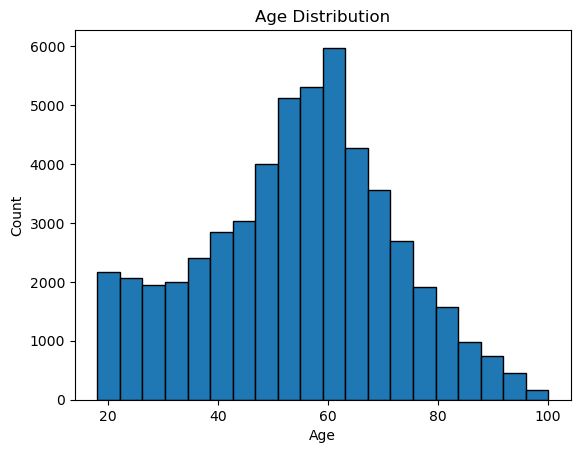

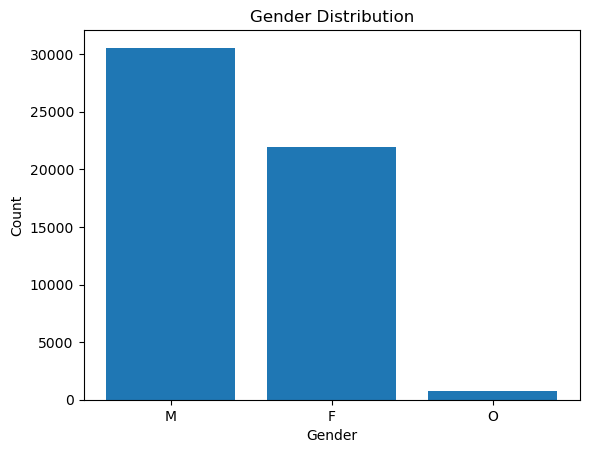

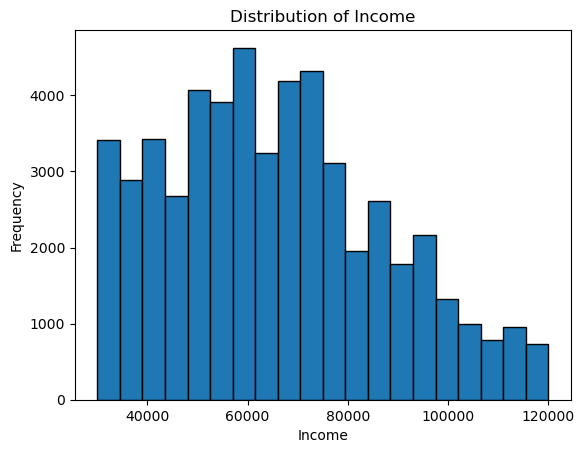

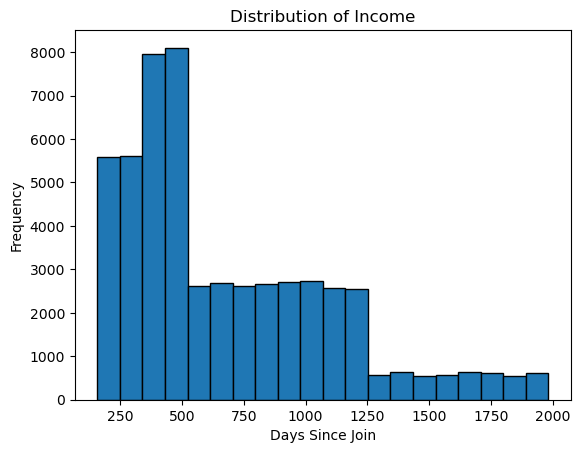

In [45]:
plt.hist(offer_profile['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

gender_counts = offer_profile['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

plt.hist(offer_profile['income'], bins=20, edgecolor='black')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Distribution of Income')
plt.show()

plt.hist(offer_profile['days_since_join'], bins=20, edgecolor='black')
plt.xlabel('Days Since Join')
plt.ylabel('Frequency')
plt.title('Distribution of Income')
plt.show()

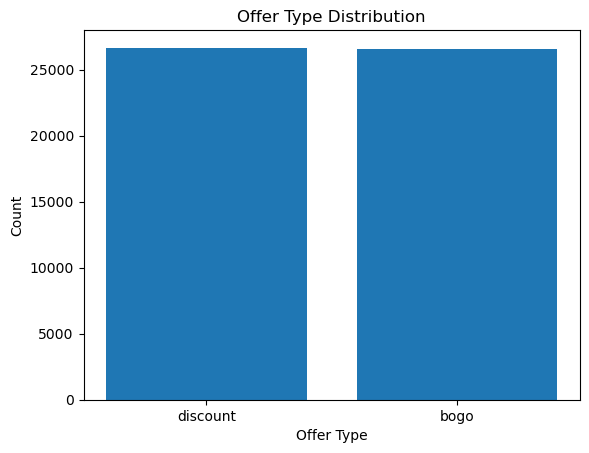

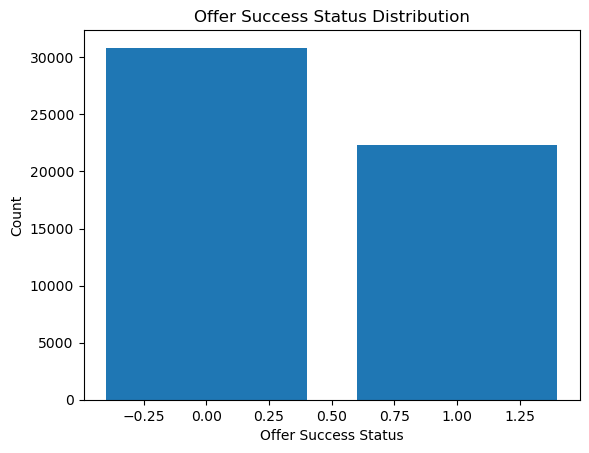

In [46]:
offer_type_counts = offer_profile['offer_type'].value_counts()
plt.bar(offer_type_counts.index, offer_type_counts.values)
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.title('Offer Type Distribution')
plt.show()

completion_counts = offer_profile['successful_offer'].value_counts()
plt.bar(completion_counts.index, completion_counts.values)
plt.xlabel('Offer Success Status')
plt.ylabel('Count')
plt.title('Offer Success Status Distribution')
plt.show()

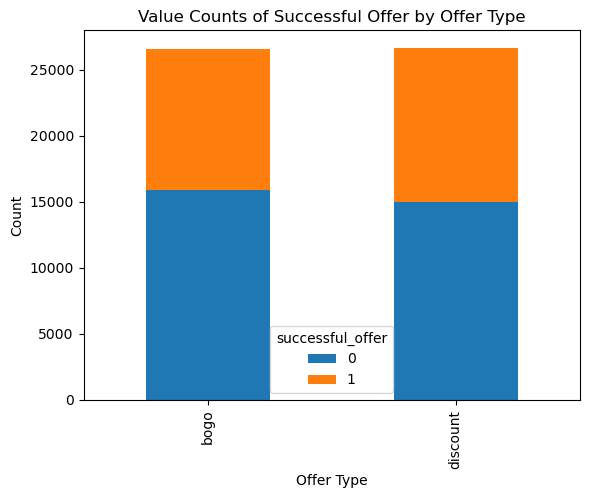

In [47]:
# Calculate the value counts of successful_offer by offer_type
offer_type_counts = offer_profile.groupby('offer_type')['successful_offer'].value_counts().unstack()

# Create the stacked bar chart
ax = offer_type_counts.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.title('Value Counts of Successful Offer by Offer Type')

# Show the plot
plt.show()


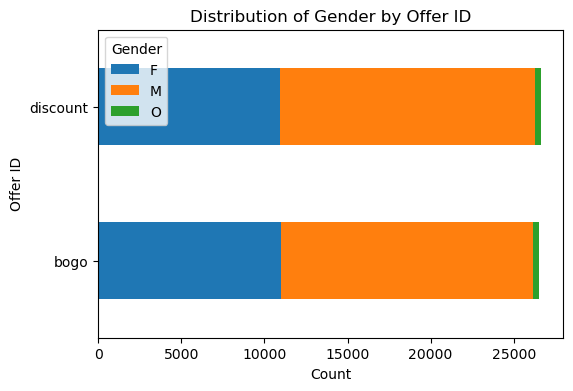

In [48]:
# Group the data by offer ID and gender
grouped_gender = offer_profile.groupby(['offer_type', 'gender']).size().unstack()

# Plot the distribution of gender by offer ID (vertical)
grouped_gender.plot(kind='barh', stacked=True, figsize=(6, 4))  # Adjust the figsize as desired
plt.title('Distribution of Gender by Offer ID')
plt.xlabel('Count')
plt.ylabel('Offer ID')
plt.legend(title='Gender')
plt.show()

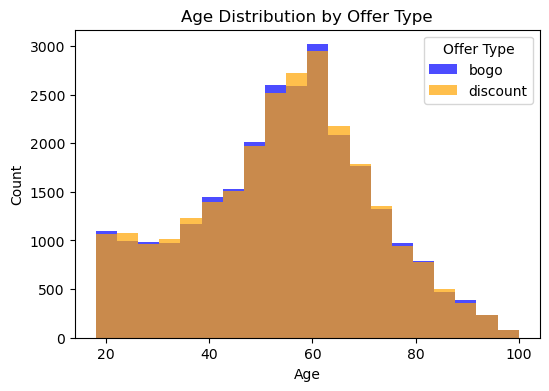

In [49]:
# Define colors for each offer type
colors = ['blue', 'orange', 'green', 'red']

# Filter the data for each offer type and select the 'age' column
offer_type_age = offer_profile.groupby('offer_type')['age']

# Plot a histogram for each offer type
plt.figure(figsize=(6, 4))  # Adjust the figsize as desired

for i, (offer_type, age_group) in enumerate(offer_type_age):
    plt.hist(age_group, bins=20, alpha=0.7, color=colors[i], label=offer_type)

plt.title('Age Distribution by Offer Type')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Offer Type')
plt.show()

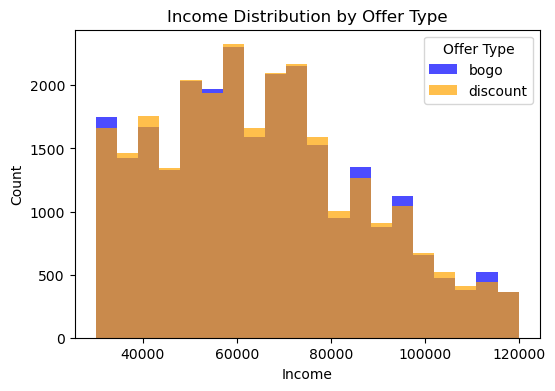

In [50]:
# Define colors for each offer type
colors = ['blue', 'orange', 'green', 'red']

# Plot a histogram for each offer type
plt.figure(figsize=(6, 4))  # Adjust the figsize as desired

# Filter the data for each offer type and select the 'age' column
offer_type_income = offer_profile.groupby('offer_type')['income']

for i, (offer_type, income_group) in enumerate(offer_type_income):
    plt.hist(income_group, bins=20, alpha=0.7, color=colors[i], label=offer_type)

plt.title('Income Distribution by Offer Type')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend(title='Offer Type')
plt.show()

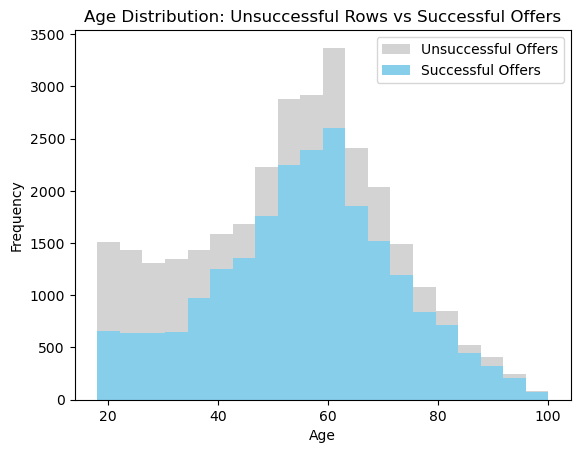

In [51]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for unsuccessful
ax.hist(offer_profile[offer_profile['successful_offer'] == 0]['age'], bins=20, color='lightgray', label='Unsuccessful Offers')

# Histogram for successful
ax.hist(offer_profile[offer_profile['successful_offer'] == 1]['age'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution: Unsuccessful Rows vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


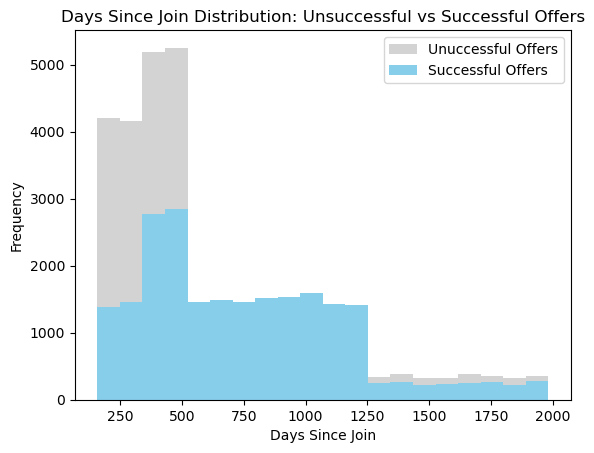

In [52]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for unsuccessful offers
ax.hist(offer_profile[offer_profile['successful_offer'] == 0]['days_since_join'], bins=20, color='lightgray', label='Unuccessful Offers')


# Histogram for successful offers
ax.hist(offer_profile[offer_profile['successful_offer'] == 1]['days_since_join'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Days Since Join')
ax.set_ylabel('Frequency')
ax.set_title('Days Since Join Distribution: Unsuccessful vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


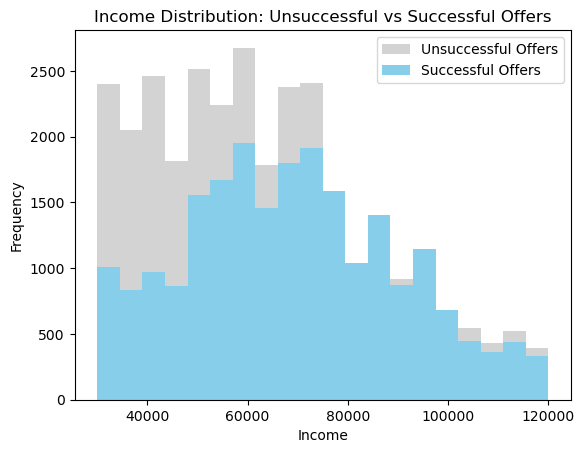

In [53]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for Unsuccessful offers
ax.hist(offer_profile[offer_profile['successful_offer'] == 0]['income'], bins=20, color='lightgray', label='Unsuccessful Offers')

# Histogram for successful offers
ax.hist(offer_profile[offer_profile['successful_offer'] == 1]['income'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_title('Income Distribution: Unsuccessful vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


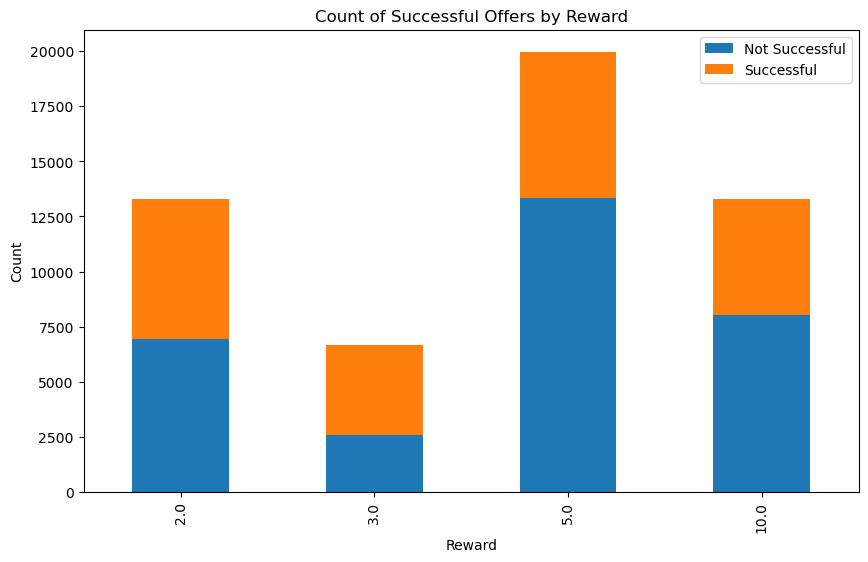

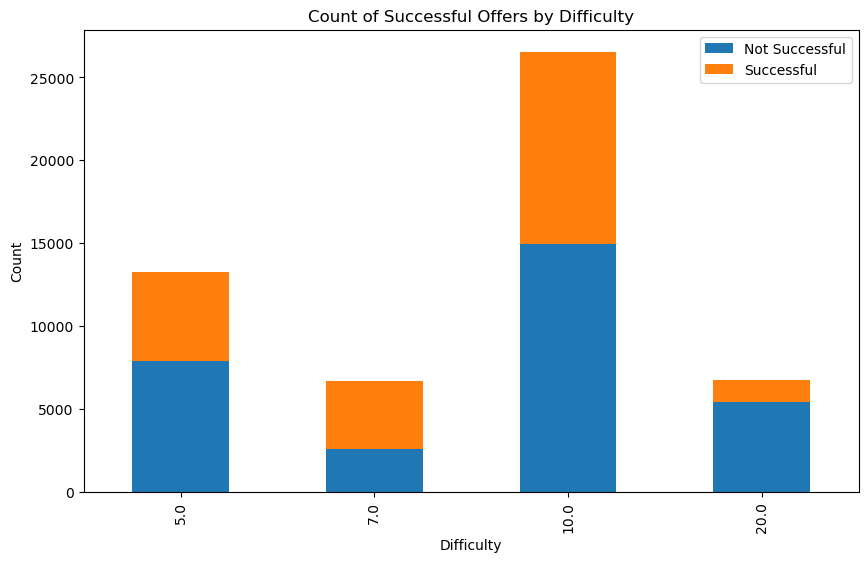

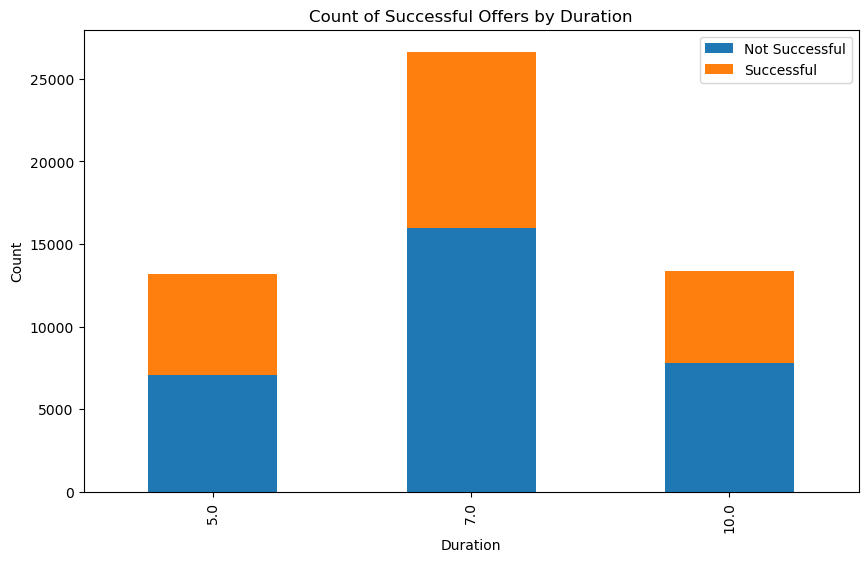

In [54]:
import matplotlib.pyplot as plt

reward_counts = offer_profile.groupby(['reward', 'successful_offer']).size().unstack()
difficulty_counts = offer_profile.groupby(['difficulty', 'successful_offer']).size().unstack()
duration_counts = offer_profile.groupby(['duration', 'successful_offer']).size().unstack()

reward_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Successful Offers by Reward')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()

difficulty_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Successful Offers by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()

duration_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Successful Offers by Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.legend(['Not Successful', 'Successful'])
plt.show()


/var/folders/z2/d7szncxs4hjf_k8p0g_s347c0000gn/T/ipykernel_41599/3029638418.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_by_offer_type = offer_profile.groupby('offer_type')['email', 'mobile', 'social', 'web'].sum()


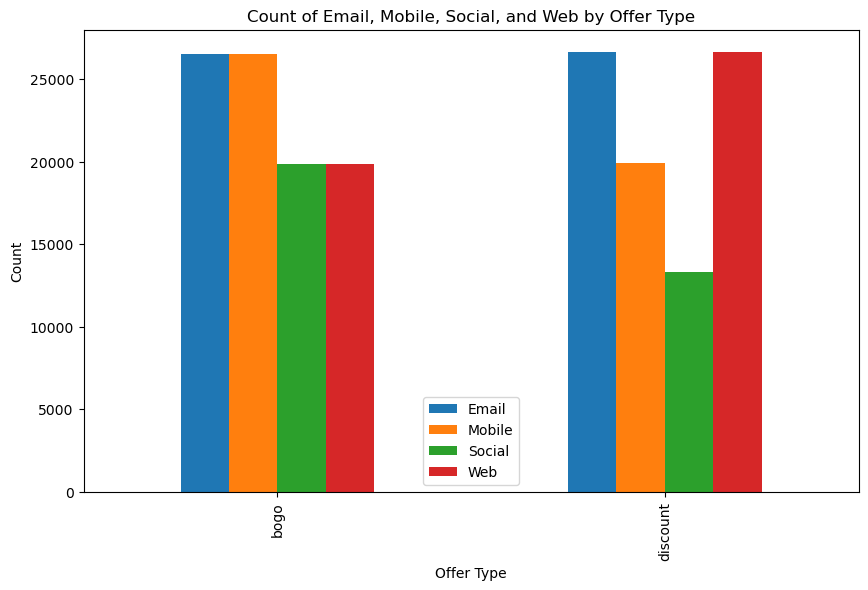

In [55]:
count_by_offer_type = offer_profile.groupby('offer_type')['email', 'mobile', 'social', 'web'].sum()

count_by_offer_type.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Email, Mobile, Social, and Web by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.legend(['Email', 'Mobile', 'Social', 'Web'])
plt.show()

## 3.2 Informational Offer

In [56]:
info_offer_profile.describe()

,age,income,days_since_join,reward,difficulty,duration,email,mobile,social,web,offer_phase,successful_offer
count,13293.000000,13293.000000,13293.000000,13293.0,13293.0,13293.000000,13293.0,13293.0,13293.000000,13293.000000,13293.000000,13293.000000
mean,54.535395,65371.699391,679.859174,0.0,0.0,3.500414,1.0,1.0,0.499586,0.500414,1.187918,0.441435
std,17.408889,21560.502867,419.134520,0.0,0.0,0.500019,0.0,0.0,0.500019,0.500019,0.437707,0.496577
min,18.000000,30000.000000,158.000000,0.0,0.0,3.000000,1.0,1.0,0.000000,0.000000,1.000000,0.000000
25%,43.000000,49000.000000,368.000000,0.0,0.0,3.000000,1.0,1.0,0.000000,0.000000,1.000000,0.000000
50%,55.000000,63000.000000,517.000000,0.0,0.0,4.000000,1.0,1.0,0.000000,1.000000,1.000000,0.000000
75%,67.000000,79000.000000,953.000000,0.0,0.0,4.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
max,100.000000,120000.000000,1980.000000,0.0,0.0,4.000000,1.0,1.0,1.000000,1.000000,5.000000,1.000000


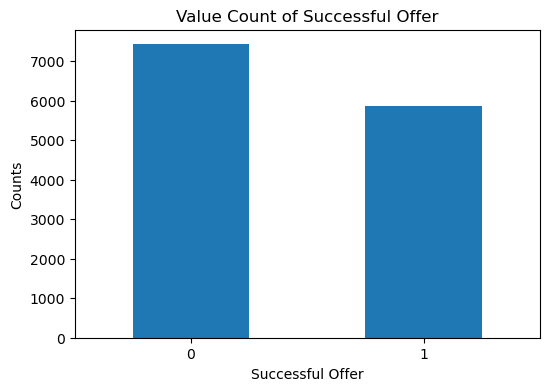

In [57]:
# Calculate the value count of successful_offer
info_offer_counts = info_offer_profile['successful_offer'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 4))
info_offer_counts.plot(kind='bar', ax=ax)

plt.title('Value Count of Successful Offer')
plt.xlabel('Successful Offer')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

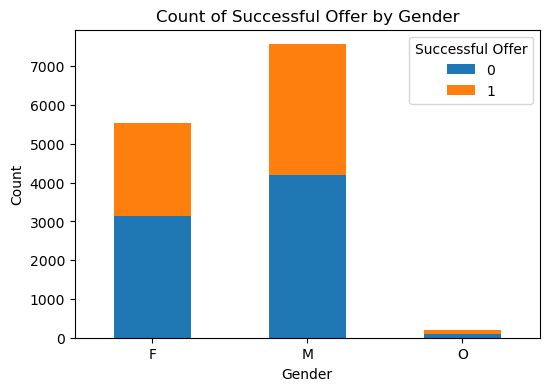

In [58]:
# Calculate the count of successful_offer by gender
gender_info_counts = info_offer_profile.groupby('gender')['successful_offer'].value_counts().unstack()

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))
gender_info_counts.plot(kind='bar', stacked=True, ax=ax)

plt.title('Count of Successful Offer by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Successful Offer')
plt.show()

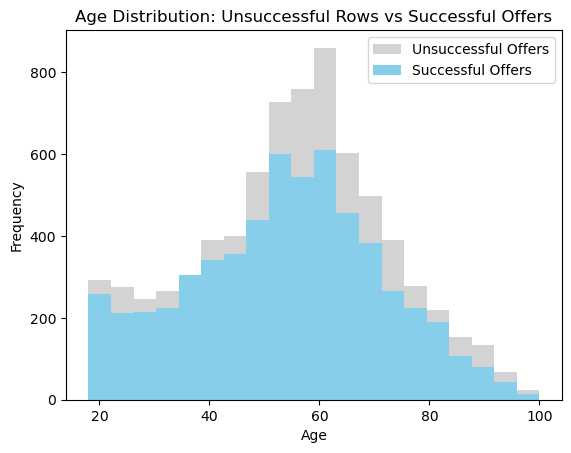

In [59]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for unsuccessful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 0]['age'], bins=20, color='lightgray', label='Unsuccessful Offers')

# Histogram for successful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 1]['age'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution: Unsuccessful Rows vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


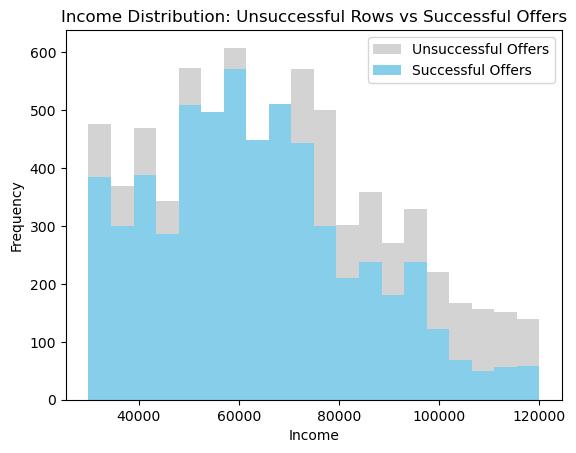

In [60]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for unsuccessful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 0]['income'], bins=20, color='lightgray', label='Unsuccessful Offers')

# Histogram for successful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 1]['income'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_title('Income Distribution: Unsuccessful Rows vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


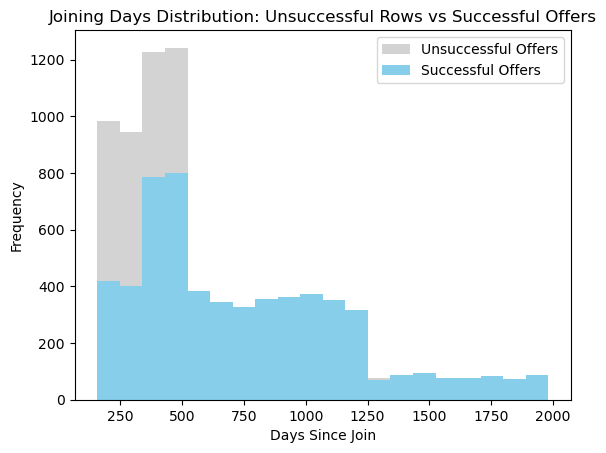

In [61]:
# Create subplots with two layers
fig, ax = plt.subplots()

# Histogram for unsuccessful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 0]['days_since_join'], bins=20, color='lightgray', label='Unsuccessful Offers')

# Histogram for successful
ax.hist(info_offer_profile[info_offer_profile['successful_offer'] == 1]['days_since_join'], bins=20, color='skyblue', label='Successful Offers')

# Set the labels and title
ax.set_xlabel('Days Since Join')
ax.set_ylabel('Frequency')
ax.set_title('Joining Days Distribution: Unsuccessful Rows vs Successful Offers')

# Add legend
ax.legend()

# Display the chart
plt.show()


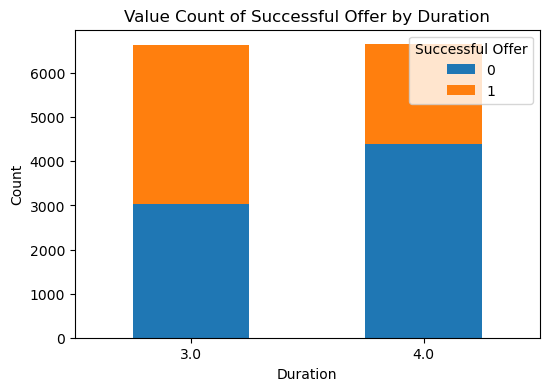

In [62]:
# Calculate the value count of successful_offer by duration
duration_counts = info_offer_profile.groupby('duration')['successful_offer'].value_counts().unstack()

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))
duration_counts.plot(kind='bar', stacked=True, ax=ax)

plt.title('Value Count of Successful Offer by Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Successful Offer')
plt.show()

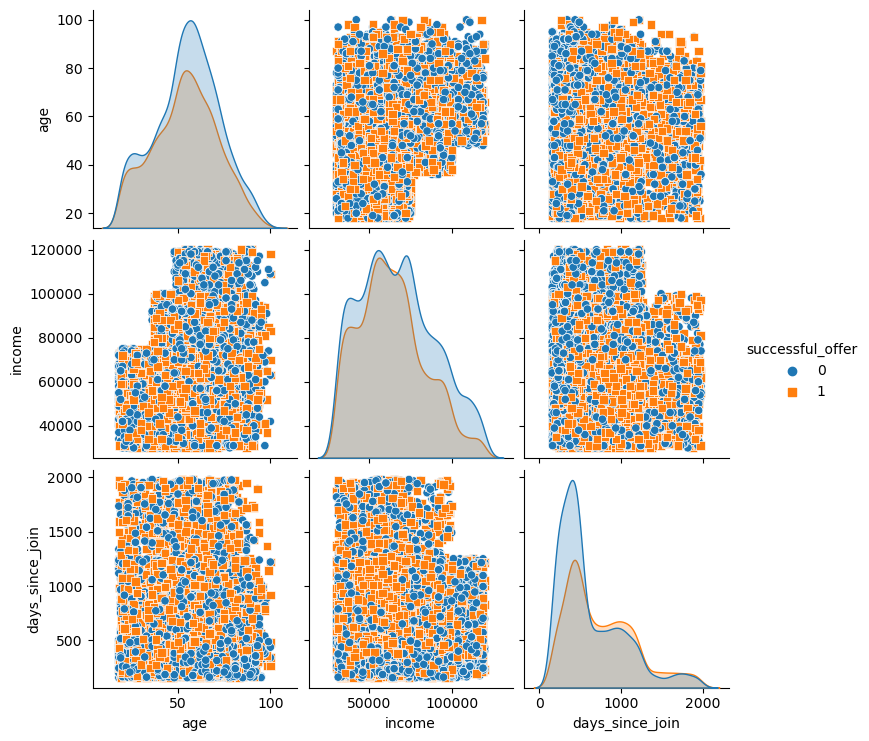

In [63]:
# Select the relevant columns from the DataFrame
data = info_offer_profile[['successful_offer', 'age', 'income', 'days_since_join']]

# Remove any rows with missing values
data = data.dropna()

# Plot the scatter plot matrix
sns.pairplot(data, hue='successful_offer', markers=['o', 's'])

# Show the plot
plt.show()

# 4. Modeling

## 4.1 Choosing Model

We have handeled both BOGO/discount offers and informational offers, they can be merged into one before we are going to train the dataset

In [64]:
offer_merged = pd.concat([offer_profile, info_offer_profile], axis=0)

In [65]:
offer_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66478 entries, 0 to 15234
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   person            66478 non-null  object        
 1   gender            66478 non-null  object        
 2   age               66478 non-null  float64       
 3   member_since      66478 non-null  datetime64[ns]
 4   income            66478 non-null  float64       
 5   days_since_join   66478 non-null  float64       
 6   offer_id          66478 non-null  object        
 7   reward            66478 non-null  float64       
 8   difficulty        66478 non-null  float64       
 9   duration          66478 non-null  float64       
 10  offer_type        66478 non-null  object        
 11  email             66478 non-null  int64         
 12  mobile            66478 non-null  int64         
 13  social            66478 non-null  int64         
 14  web               6647

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy (Random Forest):", accuracy)
print("Classification Report (Random Forest):")
print(classification_report)

Accuracy (Random Forest): 0.6617779783393501
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      7653
           1       0.61      0.56      0.58      5643

    accuracy                           0.66     13296
   macro avg       0.65      0.65      0.65     13296
weighted avg       0.66      0.66      0.66     13296



Try to use Gradient Boosting.

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the model on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Print the results
print("Accuracy(GradientBoosting):", accuracy)
print("Classification Report(GradientBoosting):")
print(classification_report_result)


Accuracy(GradientBoosting): 0.690734055354994
Classification Report(GradientBoosting):
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7653
           1       0.68      0.52      0.59      5643

    accuracy                           0.69     13296
   macro avg       0.69      0.67      0.67     13296
weighted avg       0.69      0.69      0.68     13296



And then try XGBoost.

In [68]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [69]:
import xgboost as xgb

# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy(XGBoost):", accuracy)
print("Classification Report(XGBoost):")
print(classification_report)

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy(XGBoost): 0.693892900120337
Classification Report(XGBoost):
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      7653
           1       0.66      0.57      0.61      5643

    accuracy                           0.69     13296
   macro avg       0.69      0.68      0.68     13296
weighted avg       0.69      0.69      0.69     13296



## 4.2 Model Refinement

Apply Random OverSampling to balance the class.

In [70]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [71]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler


# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the resampled training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_results = classification_report(y_test, y_pred)

# Print the results
print("Accuracy (XGB&RandomOverSampler):", accuracy)
print("Classification Report (XGB&RandomOverSampler):")
print(classification_results)

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy (XGB&RandomOverSampler): 0.6900571600481348
Classification Report (XGB&RandomOverSampler):
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      7653
           1       0.62      0.68      0.65      5643

    accuracy                           0.69     13296
   macro avg       0.69      0.69      0.69     13296
weighted avg       0.69      0.69      0.69     13296



In [72]:
from sklearn.model_selection import GridSearchCV


# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.15],  
    'max_depth': [3, 6, 9],  
    'n_estimators': [100, 200, 300], 
}

# Initialize the GridSearchCV with the XGBoost classifier and the parameter grid
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the model on the resampled training data using GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_results = classification_report(y_test, y_pred)

# Print the results
print("Best Model (XGB&RandomOverSampler&GridSearchCV):")
print(best_model)
print("Accuracy (XGB&RandomOverSampler&GridSearchCV):", accuracy)
print("Classification Report (XGB&RandomOverSampler&GridSearchCV):")
print(classification_results)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

Best Model (XGB&RandomOverSampler&GridSearchCV):
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
Accuracy (XGB&RandomOverSampler&GridSearchCV): 0.687424789410349
Classification Report (XGB&RandomOverSampler&GridSearchCV):
              precision    recall  f1-score   support

           0    

In [73]:
from sklearn.decomposition import PCA

# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

def evaluate_model_with_pca(n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_resampled)
    X_test_pca = pca.transform(X_test)

    # Initialize the XGBoost classifier
    xgb_classifier_pca = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    # Train the model on the resampled training data with PCA
    xgb_classifier_pca.fit(X_train_pca, y_train_resampled)

    # Make predictions on the test data with PCA
    y_pred = xgb_classifier_pca.predict(X_test_pca)

    # Evaluate the model with PCA
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    return accuracy, class_report

# Iterate through different numbers of components and evaluate the model
for n_components in range(1, X_train.shape[1] + 1):
    accuracy, class_report = evaluate_model_with_pca(n_components)
    
    print(f"Number of Components: {n_components}")
    print(f"Accuracy (with {n_components} components): {accuracy}")
    print(f"Classification Report (with {n_components} components):")
    print(class_report)

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 1
Accuracy (with 1 components): 0.6079271961492179
Classification Report (with 1 components):
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      7653
           1       0.53      0.60      0.56      5643

    accuracy                           0.61     13296
   macro avg       0.60      0.61      0.60     13296
weighted avg       0.62      0.61      0.61     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 2
Accuracy (with 2 components): 0.6171780986762936
Classification Report (with 2 components):
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      7653
           1       0.54      0.61      0.57      5643

    accuracy                           0.62     13296
   macro avg       0.61      0.62      0.61     13296
weighted avg       0.62      0.62      0.62     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 3
Accuracy (with 3 components): 0.6179302045728039
Classification Report (with 3 components):
              precision    recall  f1-score   support

           0       0.68      0.63      0.66      7653
           1       0.55      0.60      0.57      5643

    accuracy                           0.62     13296
   macro avg       0.61      0.62      0.61     13296
weighted avg       0.62      0.62      0.62     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 4
Accuracy (with 4 components): 0.6825361010830325
Classification Report (with 4 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 5
Accuracy (with 5 components): 0.6826113116726835
Classification Report (with 5 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 6
Accuracy (with 6 components): 0.6803549939831528
Classification Report (with 6 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.61      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 7
Accuracy (with 7 components): 0.6830625752105897
Classification Report (with 7 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 8
Accuracy (with 8 components): 0.6838146811070999
Classification Report (with 8 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.72      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.69     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 9
Accuracy (with 9 components): 0.6831377858002406
Classification Report (with 9 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 10
Accuracy (with 10 components): 0.6817839951865222
Classification Report (with 10 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.61      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 11
Accuracy (with 11 components): 0.6828369434416366
Classification Report (with 11 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.62      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.69      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 12
Accuracy (with 12 components): 0.6788507821901324
Classification Report (with 12 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.61      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.67      0.68      0.67     13296
weighted avg       0.68      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 13
Accuracy (with 13 components): 0.6792268351383874
Classification Report (with 13 components):
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7653
           1       0.61      0.67      0.64      5643

    accuracy                           0.68     13296
   macro avg       0.67      0.68      0.68     13296
weighted avg       0.68      0.68      0.68     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 14
Accuracy (with 14 components): 0.6498947051744886
Classification Report (with 14 components):
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      7653
           1       0.65      0.38      0.48      5643

    accuracy                           0.65     13296
   macro avg       0.65      0.61      0.61     13296
weighted avg       0.65      0.65      0.63     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 15
Accuracy (with 15 components): 0.6489921780986763
Classification Report (with 15 components):
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      7653
           1       0.62      0.44      0.51      5643

    accuracy                           0.65     13296
   macro avg       0.64      0.62      0.62     13296
weighted avg       0.64      0.65      0.64     13296



/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Number of Components: 16
Accuracy (with 16 components): 0.6230445246690735
Classification Report (with 16 components):
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      7653
           1       0.57      0.45      0.50      5643

    accuracy                           0.62     13296
   macro avg       0.61      0.60      0.60     13296
weighted avg       0.62      0.62      0.61     13296



The perfromance after using grid search and applying PCA are not better than applying random oversampling alone. We will stick with XGBoost+random oversampling. Now let's save the model.

In [74]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler


# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]
y = offer_merged_encoded['successful_offer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomOverSampler to the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the resampled training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_results = classification_report(y_test, y_pred)

# Print the results
print("Accuracy (XGB&RandomOverSampler):", accuracy)
print("Classification Report (XGB&RandomOverSampler):")
print(classification_results)

/Users/thomashei/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy (XGB&RandomOverSampler): 0.6900571600481348
Classification Report (XGB&RandomOverSampler):
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      7653
           1       0.62      0.68      0.65      5643

    accuracy                           0.69     13296
   macro avg       0.69      0.69      0.69     13296
weighted avg       0.69      0.69      0.69     13296



In [75]:
import pickle

# Save the model to a file using pickle
filename = 'xgb_classifier_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgb_classifier, file)

# 5. Implementation

## 5.1 Importance of Features

In [76]:
import pickle
import pandas as pd

# Load the saved model
filename = 'xgb_classifier_model.pkl'
with open(filename, 'rb') as file:
    xgb_classifier = pickle.load(file)

# Perform one-hot encoding on categorical variables
offer_merged_encoded = pd.get_dummies(offer_merged, columns=['gender', 'offer_type'])

# Split the data into features (X) and target variable (y)
X = offer_merged_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration',
                           'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                         'email', 'mobile', 'social', 'web']]

# Fit the loaded model or ensure it has already been fitted

# Determine feature importance
importances = xgb_classifier.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Print the feature importances
print("Feature importances:")
print(feature_importances)


Feature importances:
social                      0.399028
offer_type_discount         0.162341
gender_M                    0.081660
reward                      0.064515
days_since_join             0.052024
gender_O                    0.044115
income                      0.041216
difficulty                  0.040691
age                         0.025689
gender_F                    0.024460
web                         0.024177
duration                    0.022424
offer_type_bogo             0.017660
offer_type_informational    0.000000
email                       0.000000
mobile                      0.000000
dtype: float32


Native feature importances are specific to a given model and are generally based on the structure of the model itself. The importances are typically calculated based on the number of times a feature is used to split nodes in the trees, and the improvement in the model's performance gained by each split. I don't think it's reliable, let's try another metric.

In [77]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on the test set
result = permutation_importance(xgb_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features by importance in descending order
sorted_idx = result.importances_mean.argsort()[::-1]

# Print permutation importance
print("\nPermutation Importance:")
for i in sorted_idx:
    print(f"{X.columns[i]}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")


Permutation Importance:
social: 0.0768 +/- 0.0030
days_since_join: 0.0717 +/- 0.0032
income: 0.0392 +/- 0.0020
reward: 0.0251 +/- 0.0015
age: 0.0176 +/- 0.0030
difficulty: 0.0095 +/- 0.0010
offer_type_discount: 0.0069 +/- 0.0011
gender_M: 0.0039 +/- 0.0009
duration: 0.0036 +/- 0.0009
web: 0.0026 +/- 0.0008
gender_F: 0.0019 +/- 0.0010
gender_O: 0.0018 +/- 0.0003
offer_type_bogo: 0.0005 +/- 0.0004
mobile: 0.0000 +/- 0.0000
email: 0.0000 +/- 0.0000
offer_type_informational: 0.0000 +/- 0.0000


In [78]:
# Add the target variable 'successful_offer' to the encoded DataFrame
offer_merged_encoded['successful_offer'] = offer_merged['successful_offer']

# Calculate correlation matrix
correlation_matrix = offer_merged_encoded.corr()

# Get the correlation with the target variable ('successful_offer')
correlation_with_target = correlation_matrix['successful_offer']

# Remove the target variable itself from the result
correlation_with_target = correlation_with_target.drop('successful_offer')

# Sort the correlations by absolute value in descending order
sorted_correlations = correlation_with_target.reindex(correlation_with_target.abs().sort_values(ascending=False).index)

print("Correlation between features and the target variable:")
print(sorted_correlations)

Correlation between features and the target variable:
social                      0.232181
mobile                      0.158334
days_since_join             0.154925
difficulty                 -0.112497
income                      0.093144
gender_M                   -0.078434
gender_F                    0.072838
reward                     -0.067476
age                         0.048611
web                        -0.038710
offer_type_bogo            -0.038206
duration                   -0.037647
gender_O                    0.025145
offer_type_discount         0.024062
offer_type_informational    0.017297
offer_phase                -0.007419
email                            NaN
Name: successful_offer, dtype: float64


In [79]:
# Combine two tables

# Create a DataFrame to store feature importances and correlations
feature_summary = pd.DataFrame(index=X.columns)
feature_summary['Permutation Importance'] = 0
feature_summary['Permutation Importance Std'] = 0
feature_summary['Correlation'] = 0

# Add Permutation Importance values to the DataFrame
for i in sorted_idx:
    feature_summary.loc[X.columns[i], 'Permutation Importance'] = result.importances_mean[i]
    feature_summary.loc[X.columns[i], 'Permutation Importance Std'] = result.importances_std[i]

# Add correlation values to the DataFrame
for feature, value in sorted_correlations.items():
    feature_summary.loc[feature, 'Correlation'] = value

# Sort the DataFrame by Permutation Importance in descending order
feature_summary.sort_values(by='Permutation Importance', ascending=False, inplace=True)

# Display the combined table of Permutation Importance and correlation values
print("Feature Importance and Correlation:")
display(feature_summary)

Feature Importance and Correlation:


,Permutation Importance,Permutation Importance Std,Correlation
social,0.076813,0.002986,0.232181
days_since_join,0.071706,0.003200,0.154925
income,0.039170,0.001988,0.093144
reward,0.025143,0.001532,-0.067476
age,0.017584,0.003036,0.048611
difficulty,0.009499,0.000986,-0.112497
offer_type_discount,0.006897,0.001138,0.024062
gender_M,0.003896,0.000906,-0.078434
duration,0.003633,0.000860,-0.037647
web,0.002647,0.000799,-0.038710


## 5.2 Simulation

In [80]:
def calculate_successful_rate(offer_merged):
    # Calculate the successful rate of each offer
    offer_success_rate = offer_merged.groupby('offer_id')['successful_offer'].mean()

    # Count the total number of each offer
    offer_total_count = offer_merged['offer_id'].value_counts()

    # Create a DataFrame to store the results
    successful_rate = pd.DataFrame({
        'offer_id': offer_success_rate.index,
        'reward': offer_merged.groupby('offer_id')['reward'].first(),
        'difficulty': offer_merged.groupby('offer_id')['difficulty'].first(),
        'duration': offer_merged.groupby('offer_id')['duration'].first(),
        'offer_type': offer_merged.groupby('offer_id')['offer_type'].first(),
        'email':offer_merged.groupby('offer_id')['email'].first(),
        'mobile':offer_merged.groupby('offer_id')['mobile'].first(),
        'social':offer_merged.groupby('offer_id')['social'].first(),
        'web':offer_merged.groupby('offer_id')['web'].first(),
        'total_number': offer_total_count,
        'successful_rate': offer_success_rate
    })

    # Sort the DataFrame by successful_rate in descending order
    successful_rate.sort_values('successful_rate', inplace=True, ascending=False)

    # Reset the index to the default numerical index
    successful_rate.reset_index(drop=True, inplace=True)

    return successful_rate

successful_rate = calculate_successful_rate(offer_merged)

successful_rate

,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,total_number,successful_rate
0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1,1,1,1,6647,0.646006
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,discount,1,1,1,1,6654,0.615570
2,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational,1,1,1,0,6641,0.543442
3,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo,1,1,1,1,6575,0.509962
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1,1,1,1,6593,0.412407
5,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo,1,1,1,0,6683,0.382164
6,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,informational,1,1,0,1,6652,0.339597
7,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1,1,0,1,6627,0.305115
8,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1,1,0,1,6684,0.302065
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1,0,0,1,6722,0.191015


In [81]:
import os

# Set random seed for reproducibility
random.seed(42)

# Define the number of new offers to generate
num_new_offers = 10

# Define the number of each offer type
num_bogo = 4
num_discount = 4
num_informational = 2

# Define the possible values for each column
rewards = [2, 3, 4, 6, 8]
channels = [['web', 'email', 'mobile', 'social'], ['email', 'mobile'], ['web', 'mobile'], ['web', 'email'], ['web', 'email', 'mobile']]
difficulties = [15, 6, 8, 3, 4]
durations = [3, 4, 6, 7, 9, 10]
offer_types = ['bogo', 'discount', 'informational']

# Generate new offers
new_offers = []

# Generate BOGO offers
for _ in range(num_bogo):
    offer = {
        'reward': random.choice(rewards),
        'channels': random.choice(channels),
        'difficulty': random.choice(difficulties),
        'duration': random.choice(durations),
        'offer_type': 'bogo',
        'id': f'offer_{len(new_offers)}'
    }
    new_offers.append(offer)

# Generate discount offers
for _ in range(num_discount):
    offer = {
        'reward': random.choice(rewards),
        'channels': random.choice(channels),
        'difficulty': random.choice(difficulties),
        'duration': random.choice(durations),
        'offer_type': 'discount',
        'id': f'offer_{len(new_offers)}'
    }
    new_offers.append(offer)

# Generate informational offers
for _ in range(num_informational):
    offer = {
        'reward': 0,
        'channels': random.choice(channels),
        'difficulty': 0,
        'duration': random.choice(durations),
        'offer_type': 'informational',
        'id': f'offer_{len(new_offers)}'
    }
    new_offers.append(offer)

# Convert the list of offers to a DataFrame
new_offer_portfolio = pd.DataFrame(new_offers)

# Create a mapping dictionary to match offer types
offer_type_mapping = {
    'bogo': 'bogo',
    'discount': 'discount',
    'informational': 'informational'
}


# Assign the same offer IDs from offer_merged to the new offers based on their offer types
for offer_type, group in offer_merged.groupby('offer_type'):
    if offer_type in offer_type_mapping:
        offer_ids = group['offer_id'].unique()
        new_offer_portfolio.loc[new_offer_portfolio['offer_type'] == offer_type_mapping[offer_type], 'id'] = np.random.choice(offer_ids, size=len(new_offer_portfolio[new_offer_portfolio['offer_type'] == offer_type_mapping[offer_type]]), replace=False)


# Convert the DataFrame to a JSON object
new_offer_portfolio_json = new_offer_portfolio.to_json(orient='records')

# Save the JSON object to a file, replacing if it already exists
file_path = 'new_offer_portfolio.json'

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path, 'w+') as file:
    file.write(new_offer_portfolio_json)

In [82]:
# Read the JSON file and load it as a DataFrame
new_offer_portfolio = pd.read_json('new_offer_portfolio.json')

# Display the DataFrame
new_offer_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,2,"[web, email, mobile, social]",8,4,bogo,f19421c1d4aa40978ebb69ca19b0e20d
1,3,"[email, mobile]",15,10,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,8,"[web, email, mobile, social]",4,7,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,2,"[web, email, mobile, social]",15,4,bogo,ae264e3637204a6fb9bb56bc8210ddfd
4,3,"[web, email, mobile]",4,3,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
5,8,"[email, mobile]",4,7,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,3,"[web, email]",4,6,discount,2906b810c7d4411798c6938adc9daaa5
7,2,"[email, mobile]",3,6,discount,fafdcd668e3743c1bb461111dcafc2a4
8,0,"[web, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
9,0,"[email, mobile]",0,6,informational,5a8bc65990b245e5a138643cd4eb9837


In [83]:
# Preprocess the data
preprocessed_profile = preprocess_profile(profile)
preprocessed_portfolio = preprocess_portfolio(new_offer_portfolio)

In [84]:
preprocessed_portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,2,8,4,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
1,3,15,10,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0
2,8,4,7,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
3,2,15,4,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,1
4,3,4,3,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,1
5,8,4,7,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
6,3,4,6,discount,2906b810c7d4411798c6938adc9daaa5,1,0,0,1
7,2,3,6,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,0
8,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,0,1
9,0,0,6,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0


In [85]:
# Merge offer_merged with new_offer_portfolio on offer_id
offer_merged_test = offer_merged.merge(preprocessed_portfolio, how='left', left_on='offer_id', right_on='id')

# Drop the unnecessary columns from the merged dataframe
offer_merged_test.drop(['reward_x', 'difficulty_x', 'duration_x', 'offer_type_x', 'email_x', 'mobile_x', 'social_x', 'web_x'], axis=1, inplace=True)

# Rename the columns from the new_offer_portfolio to match the original column names
offer_merged_test.rename(columns={
    'reward_y': 'reward',
    'difficulty_y': 'difficulty',
    'duration_y': 'duration',
    'offer_type_y': 'offer_type',
    'email_y': 'email',
    'mobile_y': 'mobile',
    'social_y': 'social',
    'web_y': 'web'
}, inplace=True)

In [86]:
# Iterate over the rows of offer_merged_test
for index, row in offer_merged_test.iterrows():
    offer_type = row['offer_type']
    offer_id = row['id']
    
    # Lookup the features' values from preprocessed_portfolio based on offer_type and offer_id
    features = preprocessed_portfolio[(preprocessed_portfolio['offer_type'] == offer_type) & (preprocessed_portfolio['id'] == offer_id)].iloc[0]
    
    # Update the features' values in offer_merged_test
    offer_merged_test.at[index, 'reward'] = features['reward']
    offer_merged_test.at[index, 'difficulty'] = features['difficulty']
    offer_merged_test.at[index, 'duration'] = features['duration']
    offer_merged_test.at[index, 'email'] = features['email']
    offer_merged_test.at[index, 'mobile'] = features['mobile']
    offer_merged_test.at[index, 'social'] = features['social']
    offer_merged_test.at[index, 'web'] = features['web']
    
offer_merged_test.drop(['id', 'successful_offer'], axis=1, inplace=True)


In [87]:
offer_merged_test.sample(10)

,person,gender,age,member_since,income,days_since_join,offer_id,offer_phase,reward,difficulty,duration,offer_type,email,mobile,social,web
35822,9be0d577c14841bcb61232b6497db1cd,M,27.0,2017-10-18,67000.0,439.0,2906b810c7d4411798c6938adc9daaa5,1,3,4,6,discount,1,0,0,1
42314,6da3d0b813734fa3b1697119c6d75c8b,F,44.0,2017-08-05,57000.0,513.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,8,4,7,discount,1,1,0,0
14092,4909ec987247437ebf6dca3e34704b8b,M,65.0,2017-11-02,99000.0,424.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,8,4,7,discount,1,1,0,0
28714,a308e39fd73246888aff6a8262479417,M,27.0,2017-11-15,42000.0,411.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,4,3,discount,1,1,0,1
48043,6d645153138f49cc8adf6bc2abde35ab,M,57.0,2018-07-10,71000.0,174.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,8,4,7,discount,1,1,0,0
31278,955834c13c44440f98da006fde4c12dd,M,62.0,2016-01-15,33000.0,1081.0,fafdcd668e3743c1bb461111dcafc2a4,1,2,3,6,discount,1,1,0,0
50285,e31676437a8343bd816bd93067a08b89,M,63.0,2015-12-22,58000.0,1105.0,f19421c1d4aa40978ebb69ca19b0e20d,2,2,8,4,bogo,1,1,1,1
43736,dd1069bbc7ef423c9b22bc81aceb6ec1,M,32.0,2013-12-08,40000.0,1849.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,4,3,discount,1,1,0,1
169,54890f68699049c2a04d415abc25e717,M,36.0,2017-12-28,56000.0,368.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,8,4,7,discount,1,1,0,0
24285,02c8c9806a8c44f792a218fb2e8756b3,M,28.0,2018-04-29,45000.0,246.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,3,15,10,bogo,1,1,0,0


In [88]:
# Load the trained XGB model
filename = 'xgb_classifier_model.pkl'
with open(filename, 'rb') as file:
    xgb_classifier_loaded = pickle.load(file)
    
# Preprocessing
offer_merged_test_encoded = pd.get_dummies(offer_merged_test, columns=['gender', 'offer_type'])
X_test_new = offer_merged_test_encoded[['age', 'income', 'days_since_join', 'reward', 'difficulty', 'duration', 
                                        'gender_F', 'gender_M', 'gender_O', 'offer_type_informational', 'offer_type_bogo', 'offer_type_discount',
                                        'email', 'mobile', 'social', 'web']]

# Make predictions on the new test data with the loaded model
y_pred_new = xgb_classifier_loaded.predict(X_test_new)

# Create a copy of the original test dataset to store the predictions
offer_merged_test_with_predictions = offer_merged_test.copy()

# Add the predictions to the new DataFrame
offer_merged_test_with_predictions['successful_offer'] = y_pred_new


In [89]:
# Display the result DataFrame
print("Predictions for the new test dataset:")
offer_merged_test_with_predictions.sample(10)

Predictions for the new test dataset:


,person,gender,age,member_since,income,days_since_join,offer_id,offer_phase,reward,difficulty,duration,offer_type,email,mobile,social,web,successful_offer
20998,a9035280036b4e21bfe017153319c1b3,M,31.0,2013-09-15,58000.0,1933.0,2906b810c7d4411798c6938adc9daaa5,1,3,4,6,discount,1,0,0,1,0
33196,36309ec0551e4e6f8f8ff08bad4eeb8e,M,49.0,2015-09-02,81000.0,1216.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,4,3,discount,1,1,0,1,1
39781,9d73282e268c4b2c9ac4e1921011b87c,M,79.0,2015-10-07,66000.0,1181.0,ae264e3637204a6fb9bb56bc8210ddfd,1,2,15,4,bogo,1,1,1,1,1
61226,9ad81fe319ba406c96f2469926aac077,F,39.0,2016-12-13,32000.0,748.0,3f207df678b143eea3cee63160fa8bed,1,0,0,4,informational,0,1,0,1,0
24342,1f5a8953d3db4e02b8e7ea4705f6aefb,M,58.0,2015-06-13,64000.0,1297.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,8,4,7,bogo,1,1,1,1,0
6212,4c96ca31cb434fb2a0aaecc2c1961cb0,M,57.0,2018-01-21,35000.0,344.0,ae264e3637204a6fb9bb56bc8210ddfd,1,2,15,4,bogo,1,1,1,1,0
51387,ee8155c31f314673b8043c3881976c4b,F,57.0,2017-08-24,95000.0,494.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,8,4,7,discount,1,1,0,0,0
58381,6505cfc00ad24925a449efc329b33065,M,72.0,2014-05-14,40000.0,1692.0,3f207df678b143eea3cee63160fa8bed,1,0,0,4,informational,0,1,0,1,0
1150,62274260252f4b04962ec2f85295b447,M,67.0,2016-01-05,56000.0,1091.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,3,15,10,bogo,1,1,0,0,0
63978,cfdecbfe6add44598f60aed46e1f1e79,M,37.0,2016-08-03,60000.0,880.0,5a8bc65990b245e5a138643cd4eb9837,1,0,0,6,informational,1,1,0,0,1


In [90]:
test_successful_rate = calculate_successful_rate(offer_merged_test_with_predictions)

test_successful_rate

,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,total_number,successful_rate
0,f19421c1d4aa40978ebb69ca19b0e20d,2,8,4,bogo,1,1,1,1,6575,0.761977
1,ae264e3637204a6fb9bb56bc8210ddfd,2,15,4,bogo,1,1,1,1,6683,0.694299
2,4d5c57ea9a6940dd891ad53e9dbe8da0,8,4,7,bogo,1,1,1,1,6593,0.469437
3,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,0,1,0,1,6652,0.267739
4,5a8bc65990b245e5a138643cd4eb9837,0,0,6,informational,1,1,0,0,6641,0.262611
5,2906b810c7d4411798c6938adc9daaa5,3,4,6,discount,1,0,0,1,6627,0.243851
6,fafdcd668e3743c1bb461111dcafc2a4,2,3,6,discount,1,1,0,0,6647,0.239356
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,8,4,7,discount,1,1,0,0,6722,0.217048
8,2298d6c36e964ae4a3e7e9706d1fb8c2,3,4,3,discount,1,1,0,1,6654,0.201232
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,15,10,bogo,1,1,0,0,6684,0.063884
